In [1]:
import ast
import pandas as pd
import numpy as np
import time
from utils import *

from nltk.tokenize.treebank import TreebankWordDetokenizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten, Conv1D, Dropout, MaxPooling1D, GlobalMaxPooling1D, LSTM, GRU
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import tensorflow.random as random

seed = 8
random.set_seed(seed)
np.random.seed(seed)

In [2]:
embeddings_dict = {}
with open("glove.42B.300d.txt", "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        token = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[token] = vector

In [3]:
df = pd.read_csv("cleaned_data/cleaned_reviews_4.csv")
df["text"] = df["text"].apply(lambda x: ast.literal_eval(x))
df["detoken"] = df["text"].apply(lambda y: TreebankWordDetokenizer().tokenize(y))
df.head()

,review,text,rating,sentiment,detoken
0,"This started out strong, but it went downhill ...","[start, out, strong, go, downhill, fairly, qui...",1,0,start out strong go downhill fairly quickly no...
1,"A decently written YA book, but I can't even c...","[decently, write, ya, book, can, even, conside...",1,0,decently write ya book can even consider end o...
2,"Ugh...I tried, I honestly tried. I'm a huge fa...","[ugh, try, honestly, try, huge, fan, scott, we...",1,0,ugh try honestly try huge fan scott westerfeld...
3,I hate to give any book this low of a rating -...,"[hate, give, any, book, low, rat, know, take, ...",1,0,hate give any book low rat know take actually ...
4,Main points: \n 1. Never ever introduce a poin...,"[main, point, never, ever, introduce, point, v...",1,0,main point never ever introduce point view sid...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     14000 non-null  object
 1   text       14000 non-null  object
 2   rating     14000 non-null  int64 
 3   sentiment  14000 non-null  int64 
 4   detoken    14000 non-null  object
dtypes: int64(2), object(3)
memory usage: 547.0+ KB


In [42]:
df_pos, df_neg = split_sentiment(df)
df_train, df_test = split_train_test(df_pos, df_neg, 333)

train_words = [word for text in df_train["text"] for word in text]
train_text_length = [len(text) for text in df_train["text"]]

vocab = list(set(train_words))
vocab_size = len(vocab)

test_words = [word for text in df_test["text"] for word in text]
test_vocab_size = len(list(set(test_words)))

print(f"There are {len(train_words)} train words in total and the vocabulary size is {vocab_size}.")
print(f"There are {len(test_words)} test words in total and the vocabulary size is {test_vocab_size}.")

There are 1218433 train words in total and the vocabulary size is 29796.
There are 303603 test words in total and the vocabulary size is 15661.


In [43]:
train_data = df_train["detoken"].tolist()
test_data = df_test["detoken"].tolist()

MAX_WORDS = 20000
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(train_data)

word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_data)
test_sequences = tokenizer.texts_to_sequences(test_data)

MAX_LENGTH = 100

x_train_padded = pad_sequences(train_sequences, maxlen=MAX_LENGTH, padding="post")
x_test_padded = pad_sequences(test_sequences, maxlen=MAX_LENGTH, padding="post")

ytrain, ytest = np.asarray(df_train["sentiment"]), np.asarray(df_test["sentiment"])

print(x_train_padded.shape)
print(x_test_padded.shape)
print(ytrain.shape)
print(ytest.shape)
print(f"Found {len(word_index)} unique tokens")

(11200, 100)
(2800, 100)
(11200,)
(2800,)
Found 29830 unique tokens


In [44]:
vocab_train = vocab_build(df_train["text"])
vocab_test = vocab_build(df_test["text"])

train_covered, train_oov, train_vocab_coverage, train_text_coverage = embedding_coverage(df_train["text"], embeddings_dict)
test_covered, test_oov, test_vocab_coverage, test_text_coverage = embedding_coverage(df_test["text"], embeddings_dict)

print(f"Glove embeddings cover {round(train_vocab_coverage, 2)}% of vocabulary and {round(train_text_coverage, 2)}% text in training set")
print(f"Glove embeddings cover {round(test_vocab_coverage, 2)}% of vocabulary and {round(test_text_coverage, 2)}% text in testing set")

Glove embeddings cover 92.29% of vocabulary and 99.7% text in training set
Glove embeddings cover 95.84% of vocabulary and 99.72% text in testing set


In [45]:
EMBEDDING_DIM = 300
vocab_size = min(len(word_index) + 1, MAX_WORDS)

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in word_index.items():
    if i >= MAX_WORDS:
        continue
    
    try:
        embedding_vector = embeddings_dict[word]
        embedding_matrix[i] = embedding_vector
    
    except KeyError:
        embedding_vector = np.zeros(EMBEDDING_DIM)
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_LENGTH, trainable=False)

del(embedding_matrix)

#### CNN

In [46]:
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(32, 4, activation='relu'))
model.add(MaxPooling1D(4))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 300)          6000000   
                                                                 
 conv1d_9 (Conv1D)           (None, 97, 32)            38432     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 24, 32)           0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 768)               0         
                                                                 
 dense_30 (Dense)            (None, 16)                12304     
                                                                 
 dense_31 (Dense)            (None, 1)                 17        
                                                     

Epoch 1/5
123/123 [==============================] - 3s 18ms/step - loss: 0.4919 - accuracy: 0.7612 - val_loss: 0.5686 - val_accuracy: 0.7257
Epoch 2/5
123/123 [==============================] - 2s 15ms/step - loss: 0.3155 - accuracy: 0.8653 - val_loss: 0.6276 - val_accuracy: 0.6959
Epoch 3/5
123/123 [==============================] - 2s 15ms/step - loss: 0.2318 - accuracy: 0.9062 - val_loss: 0.4993 - val_accuracy: 0.7715
Epoch 4/5
123/123 [==============================] - 2s 17ms/step - loss: 0.1619 - accuracy: 0.9418 - val_loss: 0.7146 - val_accuracy: 0.6968
Epoch 5/5
123/123 [==============================] - 2s 16ms/step - loss: 0.0960 - accuracy: 0.9740 - val_loss: 0.7368 - val_accuracy: 0.7212
Training time for CNN: 10.439100980758667


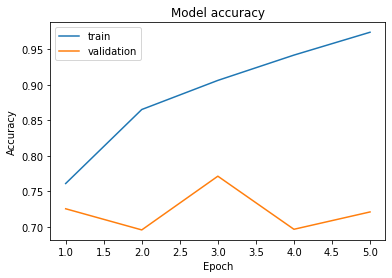

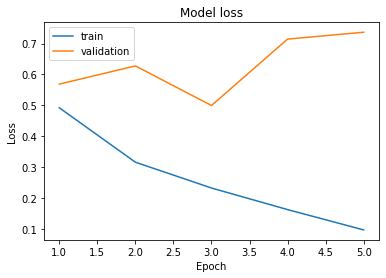

88/88 - 0s - loss: 0.4873 - accuracy: 0.8171 - 316ms/epoch - 4ms/step
Test accuracy: 0.8171428442001343
Confusion matrix: 
 [[1007  393]
 [ 119 1281]]
Test accuracy: 0.8171428571428572


In [47]:
# Compile model

EPOCHS = 5
LEARNING_RATE = 0.001

optimizer = Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Fit model

BATCH_SIZE = 64

# callbacks = [EarlyStopping(monitor='val_loss')]

tic = time.time()
history = model.fit(x_train_padded, ytrain, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.3)
toc = time.time()

print(f"Training time for CNN: {toc - tic}")

# Plot accuracy and loss

plot_history(history)

# Evaluate model

loss, accuracy = model.evaluate(x_test_padded, ytest, verbose=2)

print(f"Test accuracy: {accuracy}")

_y_pred = model.predict(x_test_padded)
y_pred = np.round(_y_pred)

print(f"Confusion matrix: \n {confusion_matrix(ytest, y_pred)}")
print(f"Test accuracy: {accuracy_score(ytest, y_pred)}")

#### LSTM

In [48]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(32))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 300)          6000000   
                                                                 
 lstm_6 (LSTM)               (None, 32)                42624     
                                                                 
 dense_32 (Dense)            (None, 16)                528       
                                                                 
 dense_33 (Dense)            (None, 1)                 17        
                                                                 
Total params: 6,043,169
Trainable params: 43,169
Non-trainable params: 6,000,000
_________________________________________________________________
None


Epoch 1/5
123/123 [==============================] - 8s 52ms/step - loss: 0.5359 - accuracy: 0.7367 - val_loss: 0.9302 - val_accuracy: 0.3752
Epoch 2/5
123/123 [==============================] - 6s 50ms/step - loss: 0.3875 - accuracy: 0.8291 - val_loss: 0.7193 - val_accuracy: 0.7682
Epoch 3/5
123/123 [==============================] - 6s 50ms/step - loss: 0.3460 - accuracy: 0.8539 - val_loss: 0.4104 - val_accuracy: 0.8676
Epoch 4/5
123/123 [==============================] - 6s 49ms/step - loss: 0.3007 - accuracy: 0.8757 - val_loss: 0.9826 - val_accuracy: 0.6090
Epoch 5/5
123/123 [==============================] - 6s 50ms/step - loss: 0.2764 - accuracy: 0.8899 - val_loss: 0.9989 - val_accuracy: 0.6186
Training time for LSTM: 32.324142932891846


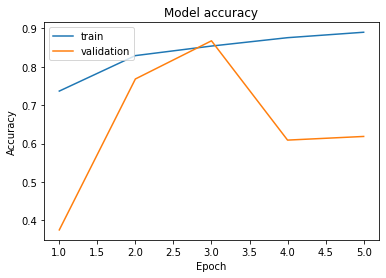

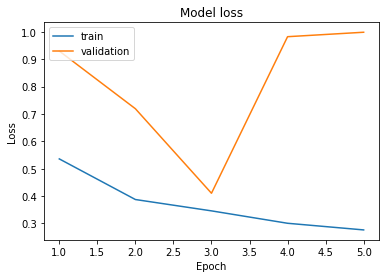

88/88 - 1s - loss: 0.5769 - accuracy: 0.7850 - 822ms/epoch - 9ms/step
Test accuracy: 0.7850000262260437
Confusion matrix: 
 [[ 850  550]
 [  52 1348]]
Test accuracy: 0.785


In [49]:
# Compile model

EPOCHS = 5
LEARNING_RATE = 0.001

optimizer = Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Fit model

BATCH_SIZE = 64

# callbacks = [EarlyStopping(monitor='val_loss')]

tic = time.time()
history = model.fit(x_train_padded, ytrain, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.3)
toc = time.time()

print(f"Training time for LSTM: {toc - tic}")

# Plot accuracy and loss

plot_history(history)

# Evaluate model

loss, accuracy = model.evaluate(x_test_padded, ytest, verbose=2)

print(f"Test accuracy: {accuracy}")

_y_pred = model.predict(x_test_padded)
y_pred = np.round(_y_pred)

print(f"Confusion matrix: \n {confusion_matrix(ytest, y_pred)}")
print(f"Test accuracy: {accuracy_score(ytest, y_pred)}")

#### GRU

In [50]:
model = Sequential()
model.add(embedding_layer)
model.add(GRU(32))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 300)          6000000   
                                                                 
 gru_6 (GRU)                 (None, 32)                32064     
                                                                 
 dense_34 (Dense)            (None, 16)                528       
                                                                 
 dense_35 (Dense)            (None, 1)                 17        
                                                                 
Total params: 6,032,609
Trainable params: 32,609
Non-trainable params: 6,000,000
_________________________________________________________________
None


Epoch 1/5
123/123 [==============================] - 8s 50ms/step - loss: 0.6049 - accuracy: 0.7118 - val_loss: 1.2033 - val_accuracy: 0.0574
Epoch 2/5
123/123 [==============================] - 6s 46ms/step - loss: 0.5259 - accuracy: 0.7484 - val_loss: 0.5750 - val_accuracy: 0.9408
Epoch 3/5
123/123 [==============================] - 6s 46ms/step - loss: 0.4414 - accuracy: 0.7623 - val_loss: 0.5748 - val_accuracy: 0.9304
Epoch 4/5
123/123 [==============================] - 6s 49ms/step - loss: 0.4287 - accuracy: 0.8203 - val_loss: 0.7428 - val_accuracy: 0.7700
Epoch 5/5
123/123 [==============================] - 6s 46ms/step - loss: 0.4046 - accuracy: 0.8382 - val_loss: 0.7012 - val_accuracy: 0.7777
Training time for GRU: 30.785088062286377


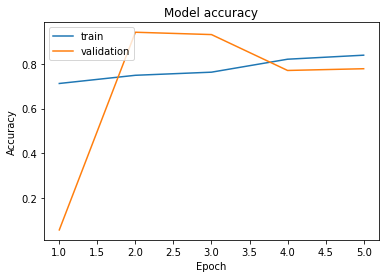

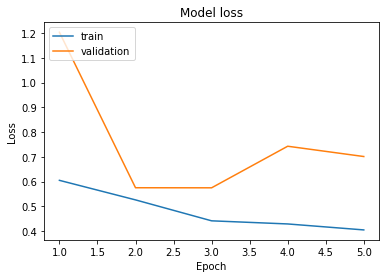

88/88 - 1s - loss: 0.4917 - accuracy: 0.8204 - 707ms/epoch - 8ms/step
Test accuracy: 0.8203571438789368
Confusion matrix: 
 [[1079  321]
 [ 182 1218]]
Test accuracy: 0.8203571428571429


In [51]:
# Compile model

EPOCHS = 5
LEARNING_RATE = 0.001

optimizer = Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Fit model

BATCH_SIZE = 64

# callbacks = [EarlyStopping(monitor='val_loss')]

tic = time.time()
history = model.fit(x_train_padded, ytrain, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.3)
toc = time.time()

print(f"Training time for GRU: {toc - tic}")

# Plot accuracy and loss

plot_history(history)

# Evaluate model

loss, accuracy = model.evaluate(x_test_padded, ytest, verbose=2)

print(f"Test accuracy: {accuracy}")

_y_pred = model.predict(x_test_padded)
y_pred = np.round(_y_pred)

print(f"Confusion matrix: \n {confusion_matrix(ytest, y_pred)}")
print(f"Test accuracy: {accuracy_score(ytest, y_pred)}")

#### CNN + LSTM

In [52]:
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(32, 4, activation="relu"))
model.add(MaxPooling1D(4))
model.add(LSTM(32))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 300)          6000000   
                                                                 
 conv1d_10 (Conv1D)          (None, 97, 32)            38432     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 24, 32)           0         
 g1D)                                                            
                                                                 
 lstm_7 (LSTM)               (None, 32)                8320      
                                                                 
 dense_36 (Dense)            (None, 16)                528       
                                                                 
 dense_37 (Dense)            (None, 1)                 17        
                                                     

Epoch 1/5
123/123 [==============================] - 5s 28ms/step - loss: 0.4758 - accuracy: 0.7745 - val_loss: 0.6466 - val_accuracy: 0.8123
Epoch 2/5
123/123 [==============================] - 3s 23ms/step - loss: 0.3253 - accuracy: 0.8613 - val_loss: 0.7812 - val_accuracy: 0.6587
Epoch 3/5
123/123 [==============================] - 3s 23ms/step - loss: 0.2669 - accuracy: 0.8904 - val_loss: 0.3406 - val_accuracy: 0.8893
Epoch 4/5
123/123 [==============================] - 3s 23ms/step - loss: 0.2024 - accuracy: 0.9198 - val_loss: 1.2522 - val_accuracy: 0.5281
Epoch 5/5
123/123 [==============================] - 3s 22ms/step - loss: 0.1643 - accuracy: 0.9377 - val_loss: 0.8464 - val_accuracy: 0.7141
Training time for CNN-LSTM: 16.123332262039185


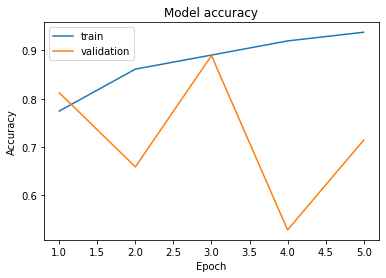

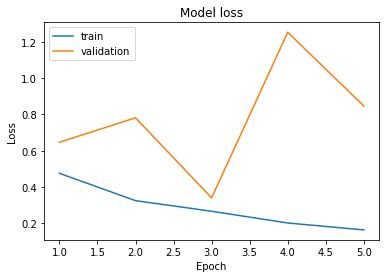

88/88 - 0s - loss: 0.5059 - accuracy: 0.8218 - 403ms/epoch - 5ms/step
Test accuracy: 0.8217856884002686
Confusion matrix: 
 [[1006  394]
 [ 105 1295]]
Test accuracy: 0.8217857142857142


In [53]:
# Compile model

EPOCHS = 5
LEARNING_RATE = 0.001

optimizer = Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Fit model

BATCH_SIZE = 64

# callbacks = [EarlyStopping(monitor='val_loss')]

tic = time.time()
history = model.fit(x_train_padded, ytrain, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.3)
toc = time.time()

print(f"Training time for CNN-LSTM: {toc - tic}")

# Plot accuracy and loss

plot_history(history)

# Evaluate model

loss, accuracy = model.evaluate(x_test_padded, ytest, verbose=2)

print(f"Test accuracy: {accuracy}")

_y_pred = model.predict(x_test_padded)
y_pred = np.round(_y_pred)

print(f"Confusion matrix: \n {confusion_matrix(ytest, y_pred)}")
print(f"Test accuracy: {accuracy_score(ytest, y_pred)}")

#### CNN + GRU

In [54]:
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(32, 4, activation="relu"))
model.add(MaxPooling1D(4))
model.add(GRU(32))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 300)          6000000   
                                                                 
 conv1d_11 (Conv1D)          (None, 97, 32)            38432     
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 24, 32)           0         
 g1D)                                                            
                                                                 
 gru_7 (GRU)                 (None, 32)                6336      
                                                                 
 dense_38 (Dense)            (None, 16)                528       
                                                                 
 dense_39 (Dense)            (None, 1)                 17        
                                                     

Epoch 1/5
123/123 [==============================] - 5s 31ms/step - loss: 0.5218 - accuracy: 0.7465 - val_loss: 0.9127 - val_accuracy: 0.5650
Epoch 2/5
123/123 [==============================] - 3s 27ms/step - loss: 0.3395 - accuracy: 0.8556 - val_loss: 0.5148 - val_accuracy: 0.8081
Epoch 3/5
123/123 [==============================] - 3s 26ms/step - loss: 0.2560 - accuracy: 0.8971 - val_loss: 0.2994 - val_accuracy: 0.9000
Epoch 4/5
123/123 [==============================] - 3s 28ms/step - loss: 0.2016 - accuracy: 0.9209 - val_loss: 1.3038 - val_accuracy: 0.5293
Epoch 5/5
123/123 [==============================] - 3s 25ms/step - loss: 0.1379 - accuracy: 0.9515 - val_loss: 0.6499 - val_accuracy: 0.7783
Training time for CNN-GRU: 18.581244230270386


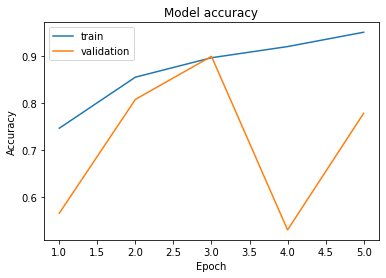

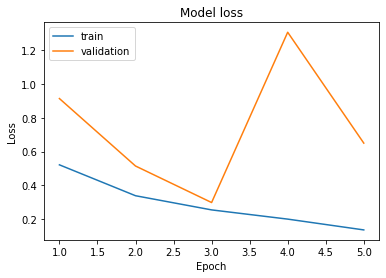

88/88 - 0s - loss: 0.4574 - accuracy: 0.8371 - 335ms/epoch - 4ms/step
Test accuracy: 0.8371428847312927
Confusion matrix: 
 [[1081  319]
 [ 137 1263]]
Test accuracy: 0.8371428571428572


In [55]:
# Compile model

EPOCHS = 5
LEARNING_RATE = 0.001

optimizer = Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

# Fit model

BATCH_SIZE = 64

# callbacks = [EarlyStopping(monitor='val_loss')]

tic = time.time()
history = model.fit(x_train_padded, ytrain, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_split=0.3)
toc = time.time()

print(f"Training time for CNN-GRU: {toc - tic}")

# Plot accuracy and loss

plot_history(history)

# Evaluate model

loss, accuracy = model.evaluate(x_test_padded, ytest, verbose=2)

print(f"Test accuracy: {accuracy}")

_y_pred = model.predict(x_test_padded)
y_pred = np.round(_y_pred)

print(f"Confusion matrix: \n {confusion_matrix(ytest, y_pred)}")
print(f"Test accuracy: {accuracy_score(ytest, y_pred)}")